# Integrated Inference Pipeline Test

This notebook verifies the **Full End-to-End Pipeline**:
1. **Stage 0**: Input Validation (YOLOv11) -> Filters Irrelevant/Background
2. **Stage 1**: Binary Triage (EfficientNet) -> Wound vs Healthy Skin
3. **Stage 2**: Wound Classification (EfficientNet) -> Identifies Wound Type

The pipeline should automatically route the image through these models.

In [1]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import glob
import random

# Add src to path
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT / "src"))

from inference_pipeline import InferencePipeline

print(f"Project Root: {PROJECT_ROOT}")

f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project Root: F:\Housepital-AI\Housepital-AI\AI_Pipeline_V2


## 1. Initialize Pipeline

In [2]:
# Force paths if needed, otherwise rely on defaults in the script
try:
    pipeline = InferencePipeline()
    print("✅ Pipeline Initialized Successfully")
except Exception as e:
    print(f"❌ Initialization Failed: {e}")
    # Attempt to debug path issues if any
    print(f"Current CWD: {os.getcwd()}")

✅ Stage 0 (YOLOv11) Loaded on cuda


f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


✅ Stage 1 (EfficientNet Binary) Loaded on cuda
✅ Stage 2 (Wound Type) Loaded on cuda
✅ Pipeline Initialized Successfully


## 2. Visualization Helper

In [3]:
def run_and_show(image_path):
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return
        
    # Run Inference
    try:
        result = pipeline.predict(image_path)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    # Parse Results
    final_msg = result.get('final_verdict', 'Unknown')
    s0 = result.get('stage0', {})
    s1 = result.get('stage1', {})
    s2 = result.get('stage2', {})
    
    # Title Info
    title = f"Verdict: {final_msg}\n"
    title += f"S0 (Filter): {s0.get('class')} ({s0.get('confidence', 0):.2f})"
    
    if s1:
        title += f" | S1 (Binary): {'Wound' if s1.get('is_wound') else 'Healthy'} ({s1.get('probability', 0):.2f})"
    
    if s2:
        title += f"\nS2 (Type): {s2.get('type')} ({s2.get('confidence', 0):.2f})"

    # Display
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    
    # Color Code Title
    if "Irrelevant" in final_msg:
        color = 'gray'
    elif "Healthy" in final_msg:
        color = 'green'
    else:
        color = 'red'
        
    plt.title(title, color=color, fontsize=10)
    plt.show()

## 3. Run Tests


--- Testing Category: Background ---


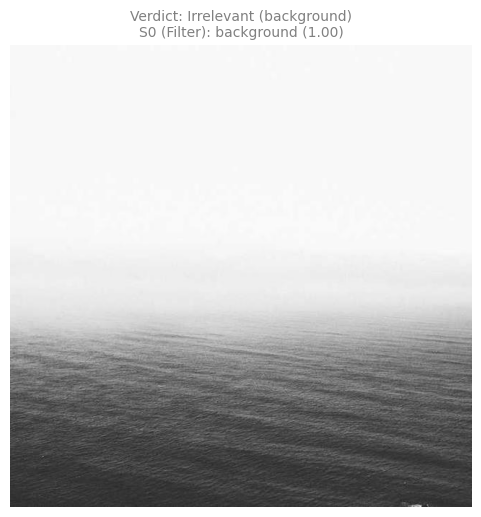


--- Testing Category: Healthy ---


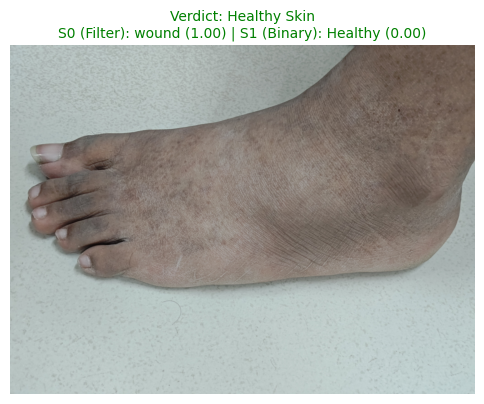


--- Testing Category: Diabetic Foot ---


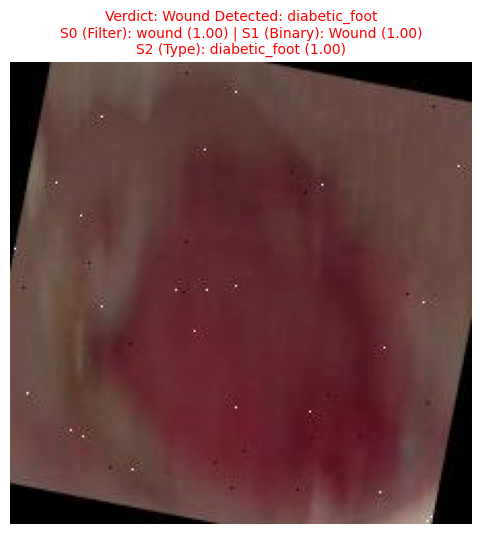


--- Testing Category: Cut ---


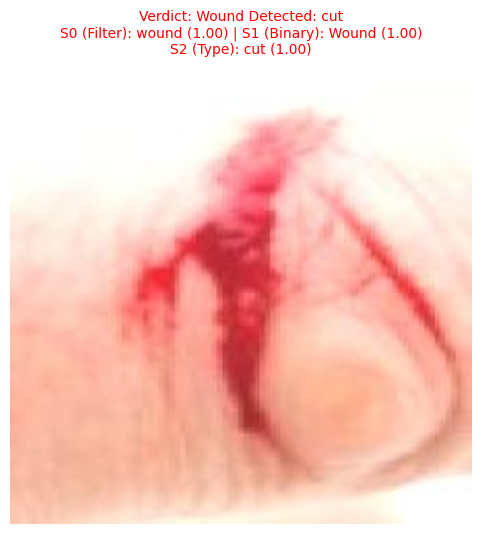


--- Testing Category: Burn ---


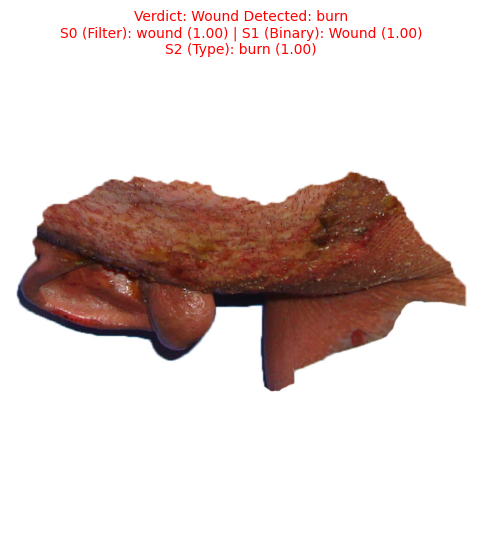


--- Testing Category: Surgical ---


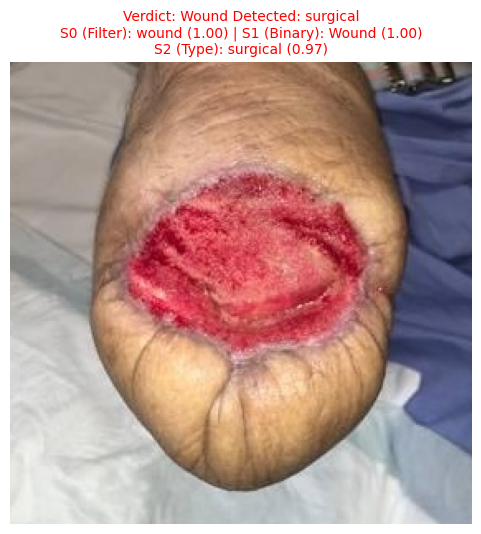


--- Testing Category: Abrasion ---


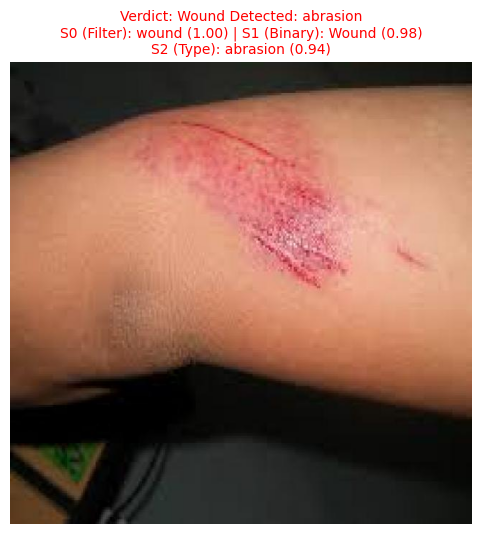


--- Testing Category: Bruise ---


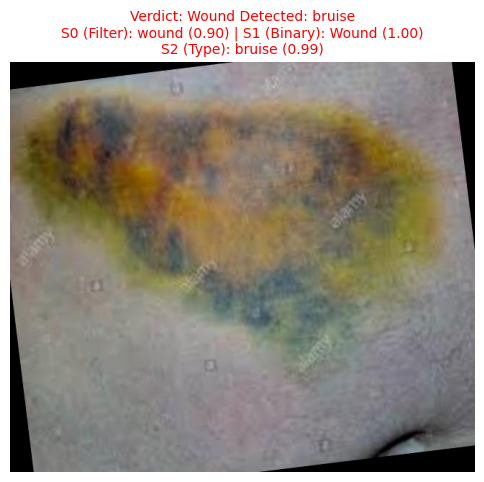


--- Testing Category: Laceration ---


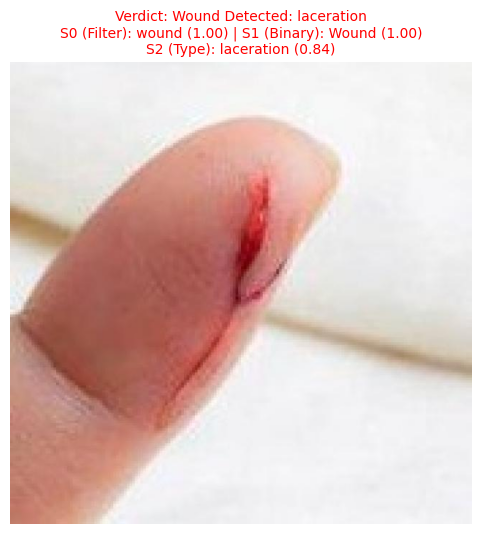

In [5]:
# Collect Samples
data_root = PROJECT_ROOT / "data" / "raw"

# defines categories to test
categories = {
    "Background": data_root / "background_class_highres",
    "Healthy": data_root / "type_classification" / "healthy",
    "Diabetic Foot": data_root / "type_classification" / "diabetic_foot",
    "Cut": data_root / "type_classification" / "cut",
    "Burn": data_root / "type_classification" / "burn",
    "Surgical": data_root / "type_classification" / "surgical",
    "Abrasion": data_root / "type_classification" / "abrasion",
    "Bruise": data_root / "type_classification" / "bruise",
    "Laceration": data_root / "type_classification" / "laceration",
    
}

# Run 1 random sample from each
for cat_name, path in categories.items():
    print(f"\n--- Testing Category: {cat_name} ---")
    files = list(path.glob("*.jpg")) + list(path.glob("*.png"))
    if files:
        sample = random.choice(files)
        run_and_show(sample)
    else:
        print(f"No images found in {path}")